In [8]:
import SimpleITK as sitk
import os
import matplotlib.pyplot as plt
import numpy as np
from torch import nn

In [2]:
path = "training_data"
training_data = []
for entry in os.listdir(path):
    full_path = os.path.join(path, entry, 'func')
    if entry.startswith('sub'):
        for echo in os.listdir(full_path):
            if 'echo-1' in echo and echo.endswith('nii.gz'):
                data_path = os.path.join(full_path, echo)
                raw_img_sitk = sitk.ReadImage(data_path, sitk.sitkFloat32)
                raw_img_sitk_arr = sitk.GetArrayFromImage(raw_img_sitk)
                training_data.append(raw_img_sitk_arr)

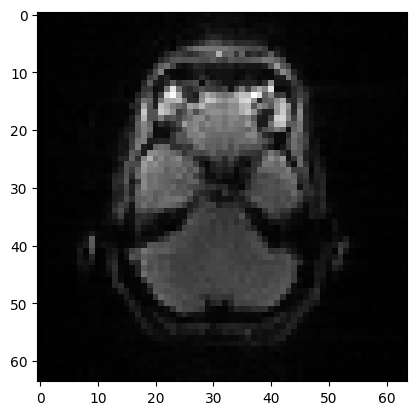

In [31]:
plt.imshow(training_data[2][10][5], cmap='gray')
plt.show()

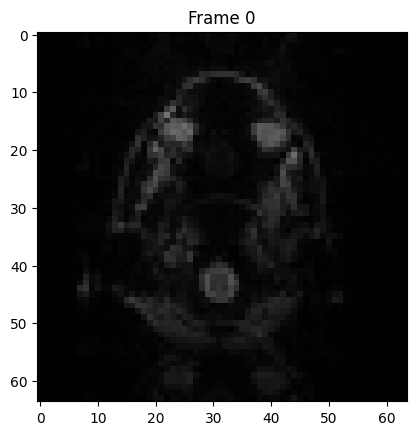

In [37]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Create figure and initial frame
fig, ax = plt.subplots()
img = ax.imshow(training_data[2][0][6], cmap='gray', animated=True)

# Update function for animation
def update(frame):
    img.set_array(training_data[2][0][frame])
    ax.set_title(f"Frame {frame}")
    return [img]

# Create animation (frames 0239)
ani = animation.FuncAnimation(
    fig, update, frames=range(30), interval=100, blit=True, repeat=True
)

plt.show()


In [38]:
ani.save("image_sequence.gif", writer='pillow', fps=10)

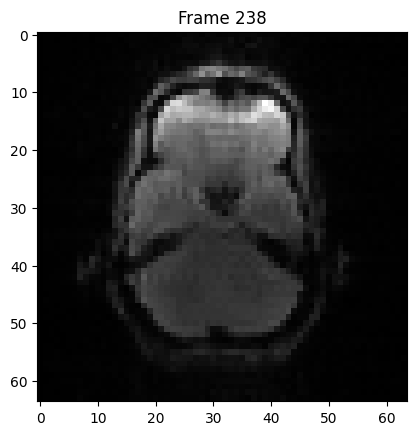

In [18]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Create figure
fig, ax = plt.subplots()
img = ax.imshow(training_data[2][0][6], cmap='gray', animated=True)

# Update function
def update(frame):
    img.set_array(training_data[2][frame][6])
    ax.set_title(f"Frame {frame}")
    return [img]

# Create animation (0239 frames)
ani = animation.FuncAnimation(
    fig, update, frames=range(239), interval=100, blit=True, repeat=True
)

# Display inline
HTML(ani.to_jshtml())


In [4]:
training_data_np = np.array(training_data)

In [5]:
training_data_np.shape

(80, 239, 30, 64, 64)

In [32]:
training_one_slice_one_time = []
for subj in training_data_np:
    #10th time slice
    #5th slice
    training_one_slice_one_time.append(subj[10][5])

In [33]:
training_one_np = np.array(training_one_slice_one_time)

In [34]:
training_one_np.shape

(80, 64, 64)

In [9]:
class ConvBlock(nn.Sequential):
    """Conv + Activation"""
    def __init__(self, in_channels, mid_channels, out_channels=None, nb_conv=2, kernel_size=3):
        out_channels = out_channels or mid_channels
        super().__init__(
            nn.Conv2d(in_channels, mid_channels, kernel_size=kernel_size, padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=kernel_size, padding='same'),
            nn.ReLU(inplace=False),
        )

    def forward_skip(x): #x(16)
        """Use this function when we want to save the last pre-activation value"""
        second_to_last = None
        for layer in self:
            second_to_last = x
            x = layer(x)
        return x, second_to_last


class UNet(nn.Module):

    def __init__(self, in_channels, out_channels):
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.encoder = nn.Sequential(
            ConvBlock(in_channels, 8),
            ConvBlock(8, 16),
            ConvBlock(16, 32),
        )
        self.bottleneck = ConvBlock(32, 64, 32)
        self.decoder = nn.Sequential(
            ConvBlock(64, 16),
            ConvBlock(32, 8),
            ConvBlock(16, 8),
        )
        self.conv_last = nn.Conv2d(8, out_channels, kernel_size=1)

    def forward(x): # x(16)
        skips = []
        for layer in self.encoder:
            x, skip = layer.forward_skip(x)
            x = self.maxpool(x)
            skips += [skip]
            
        x = self.bottleneck(x)
        
        for layer, skip in zip(self.decoder, skips):
            x = torch.cat([self.upsample(x), skip], dim=1)
            x = layer(x)
        x = self.conv_last(x)
        return x
            
